# Data Ingestion and BERT Preparation

# A. Environment Setup

In [1]:
!pip install bert-for-tf2
!pip install sentencepiece

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split

import io
import os
import math
import zipfile
import time

from tqdm import tqdm
from pprint import pprint

# Suppress new window for plots
%matplotlib inline 

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import bert

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# B. Functions

## B.1 Global Variables

In [0]:
path_to_data = "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"
zip_filename = "ticket_data_10_years_post_rtf.zip"
#csv_filename = "ticket_data_10_years_post_rtf.csv"
csv_filename = "ticket_data_dec_19_post_rtf.csv"

## B.2 Data Pre-Processing Functions

In [0]:
def text_company(df, text_field):  
  print("Starting text_company()...")
  start = time.time()
  df[text_field] = df[text_field].str.lower()
  end = time.time()
  print("Finished making it lowercase:", (end - start))
  
  start = time.time()  
  df[text_field] = df[text_field].str.replace(r"greenshades support", "clientswsupport")
  end = time.time()
  print("Finished removing 'greenshades support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades software support", "clientswsupport")
  end = time.time()  
  print("Finished removing 'greenshades software support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades partner support", "partnerswsupport")
  end = time.time()
  print("Finished removing 'greenshades partner support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades ticket", "ticket")
  end = time.time()
  print("Finished removing 'greenshades ticket':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades online", "")
  end = time.time()
  print("Finished removing 'greenshades online':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"www.greenshades.com", "")
  end = time.time()
  print("Finished removing 'www.greenshades.com':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshadesonline.com", "")
  end = time.time()
  print("Finished removing 'greenshadesonline.com':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades", "")
  end = time.time()
  print("Finished removing 'greenshades':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"green shades", "")
  end = time.time()
  print("Finished removing 'green shades':", (end - start))
  print("Finished text_company().")
  return df

In [0]:
def text_normalize(df, text_field):
  print("Starting text_normalize()...")
  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"<[^>]+>", "") # Delete any string between "<" and ">"
  end = time.time()
  print("Finished deleting strings between <>")
  print (end - start)

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"www.*?.com", "") 
  end = time.time()
  print("Finished deleting websites:", (end - start))

  start = time.time()
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
  end = time.time()
  print("Finished deleting http\S+:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"\d+", "") # Remove any strings of numbers
  end = time.time()
  print("Finished deleting numbers:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
  end = time.time()
  print("Finished removing S+:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9\.\=]", " ")
  end = time.time()
  print("Finished removing non-alpha numerics excluding punctuation (.=):", (end - start)) # old .,;:!

  print("Finished text_normalize().")
  return df

In [0]:
def tokens_to_string(input_list):
  return ' '.join(input_list)

## B.3 Plotting Functions

In [0]:
def plot_cm(y_true, y_pred, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    fig, ax = plt.subplots(figsize=figsize)
    colormap = sns.diverging_palette(220, 20, sep=20, as_cmap=True) #plt.cm.coolwarm #coolwarm_r reverse
    sns.heatmap(cm, 
                cmap=colormap, 
                annot=annot, 
                annot_kws={"size": 12}, 
                fmt='',
                linewidths=1, 
                square=True, 
                ax=ax)
    ax.set_title('Confusion Matrix\n', fontsize=16, weight='bold');
    ax.set_xlabel('\n\nPredicted Label', fontsize=12);
    ax.set_ylabel('Actual Label\n\n', fontsize=12);

## B.4 Utility Functions

In [0]:
priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3}
def map_priority(priority, priority_dict = {}):
  val = priority_dict[priority]
  return val

In [0]:
def tokenize_note(note):
  '''Simple wrapper for tokenizing a note to its ids.'''
  return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(note))

In [0]:
def truncate_tokenized_note(tokenized_note,length):
  '''Truncates a tokenized note to the specified number of tokens(length).'''
  if len(tokenized_note) > length:
    tokenized_note = tokenized_note[:length]
  return tokenized_note

In [0]:
def create_tokenized_field(df, text_field, new_token_field):
  print("Starting create_tokenized_field()...")
  printAfter = 500000
  print("Total lines in loop")
  print(len(df[text_field]))
  start = time.time()

  new_tokens = [[]]*len(df[text_field])

  token_time = 0
  filter_time = 0
  assign_to_token_time = 0  

  for i in range(0, len(df[text_field])):
    start_inner = time.time()
    tokens = word_tokenize(df[text_field][i])
    end_inner = time.time()
    token_time += (end_inner - start_inner)

    start_inner = time.time()    
    filtered_tokens = [w for w in tokens]
    end_inner = time.time()
    filter_time += (end_inner - start_inner)

    start_inner = time.time()        
    new_tokens[i] = filtered_tokens
    end_inner = time.time()
    assign_to_token_time += (end_inner - start_inner)

    if i % printAfter == 0 and i != 0:      
      print("Finished lines:", i)
      print("Token Time:", token_time)
      print("Filter Time:", filter_time)
      print("Assign To Token Time:", assign_to_token_time)      
      token_time = 0
      filter_time = 0
      assign_to_token_time = 0    
      
  df[new_token_field] = new_tokens
  end = time.time()
  print("Create tokenized field time:", (end - start))
  start = time.time()

  print("Finished create_tokenized_field().")
  return df

## B.5 BERT Data Preparation Functions

In [0]:
def create_single_input(sentence, MAX_LEN):
  stokens = tokenizer.tokenize(sentence)
  stokens = stokens[:MAX_LEN]
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids, masks, segments

In [0]:
def create_input_array(sentences):
  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
    ids, masks, segments = create_single_input(sentence, MAX_SEQ_LEN-2)
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32),
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

In [0]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

# C. Ingest and Pre-Process Dataset

## C.1 Import Raw Dataset

In [0]:
#unzip data, only run if unzipped data not present in your Google Drive
#with zipfile.ZipFile(path_to_data + zip_filename, 'r') as zip_ref:
#    zip_ref.extractall(path_to_data)

In [19]:
start = time.time()
ticket_data = pd.read_csv(path_to_data + csv_filename, dtype = {'Notes': str})
ticket_data.Notes = ticket_data.Notes.fillna(' ')
end = time.time()
print("Loaded File:", (end - start))

Loaded File: 0.48918724060058594


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
# count the number of empty notes
count_empty = 0
for i in range(0, len(ticket_data['Notes'])):
  note = ticket_data['Notes'][i].strip()
  if len(note) == 0:
    count_empty += 1
  
print("Number of Blank Notes", count_empty)
print("Blank Note %:", count_empty / len(ticket_data['Notes']))

Number of Blank Notes 4135
Blank Note %: 0.14590169718781976


## C.2 View Dataframe

In [21]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28341 entries, 0 to 28340
Data columns (total 71 columns):
BugActionID                 28341 non-null int64
BugID                       28341 non-null int64
ActionUserID                28341 non-null object
ActionTime                  28341 non-null object
AssignedID                  28341 non-null object
Notes                       28341 non-null object
StatusID                    28341 non-null object
PriorityID                  28341 non-null object
BAContactID                 26734 non-null float64
UpdateType                  26727 non-null object
ResolutionID                24412 non-null float64
ClientTouched               22000 non-null object
CodeChanged                 20338 non-null object
ClientEmailed               20338 non-null object
ClientPhoned                20338 non-null object
UserDepartment              21757 non-null object
UserPosition                22967 non-null object
NextBugActionID             22303 non-nul

## C.3 Sequence by BugID

In [22]:
#First, ensure that the dataframe is in the correct order. This should probably first be moved up to the data pre-processing.
ticket_data = ticket_data.sort_values(['BugID','ActionOrder'])

#group the data on the BugID and aggregate all of the features into lists for each feature. List maintains insertion order
# following the sort on ActionOrder above.
ticket_data_sequenced = ticket_data.groupby('BugID').aggregate(lambda attr: attr.tolist())
#examine the sequenced data
ticket_data_sequenced.head()

,BugActionID,ActionUserID,ActionTime,AssignedID,Notes,StatusID,PriorityID,BAContactID,UpdateType,ResolutionID,ClientTouched,CodeChanged,ClientEmailed,ClientPhoned,UserDepartment,UserPosition,NextBugActionID,LastTouchPrevToCloseID,OpenAfterCloseID,NextCloseConfirmedID,RawHours,BusinessHours,LastCloseID,ActionOrder,RedirectStatus,Title,Directory,ProductID,ReportedID,Description,compid,contactid,Originated,KBArticleID,CurrentResolutionID,OpenedTime,LastBugActionID,WasLow,WasAssignedToDev,LastBugActionStatus,NumBugActions,LastContact,WasEscalatedPastRepLevel,WorkspaceID,Summary,ClientTemp,MajorityPriorityID,SupportFailbyDev,SupportFailConfirm,Classification,HighestPriorityID,owner,IsEFP,LastRedirectStatus,ChangeDateTime,HistorySummary,HistoryClientTemp,UserID,ClosestBugActionID,ArticleID,KBTitle,NumUses,NumTimesEscalated,DefaultPriorityID,PackageID,KBProductID,Active,UserFriendlyDesc,SalesProductGroupID,DefaultClassification
BugID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
505111,"[3486141, 3486142, 3486361, 3486397, 3486423]","[TaxServiceSupport, TaxServiceSupport, jbaughn...","[2019-12-01 09:56:38.470000000, 2019-12-01 09:...","[TaxServiceSupport, Tax Service Support, TFC/P...","[(Created), **EFP-Auto-Ticket-Action** Error ...","[Open, In Progress, In Progress, Fixed, Closed]","[Normal, Normal, Normal, Normal, Normal]","[41190.0, 41190.0, 41190.0, 41190.0, 41190.0]","[Opened, Working, Redirected, Fixed, Worked]","[nan, nan, 0.0, 0.0, 0.0]","[nan, nan, False, False, True]","[nan, nan, False, False, False]","[nan, nan, False, False, True]","[nan, nan, False, False, False]","[nan, nan, Payroll Tax Service, Development, P...","[nan, nan, Tax Service Support Manager, Develo...","[3486142.0, 3486361.0, 3486397.0, 3486423.0, nan]","[nan, nan, nan, nan, 3486397.0]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[0.0, 23.8833, 0.2, 0.2167, nan]","[0.0, 0.8167, 0.2, 0.2167, nan]","[nan, nan, nan, nan, 3486423.0]","[1, 2, 3, 4, 5]","[nan, nan, nan, nan, nan]","[EFP: Submission hung or stalling, EFP: Submis...","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[TaxServiceSupport, TaxServiceSupport, TaxServ...","[Error in EFP, Error in EFP, Error in EFP, Err...","[3701, 3701, 3701, 3701, 3701]","[41190, 41190, 41190, 41190, 41190]","[nan, nan, nan, nan, nan]","[1545, 1545, 1545, 1545, 1545]","[0.0, 0.0, 0.0, 0.0, 0.0]","[2019-12-01 14:56:37.973000000, 2019-12-01 14:...","[3486423, 3486423, 3486423, 3486423, 3486423]","[False, False, False, False, False]","[True, True, True, True, True]","[Closed, Closed, Closed, Closed, Closed]","[5, 5, 5, 5, 5]","[2019-12-02 10:14:47.060000000, 2019-12-02 10:...","[True, True, True, True, True]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[Not Support Related, Not Support Related, Not...","[Normal, Normal, Normal, Normal, Normal]","[nan, nan, nan, nan, nan]","[True, True, True, True, True]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1545, 1545, 1545, 1545, 1545]","[EFP: Submission hung or stalling, EFP: Submis...","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[High, High, High, High, High]","[-1, -1, -1, -1, -1]","[40, 40, 40, 40, 40]","[0, 0, 0, 0, 0]","[nan, nan, nan, nan, nan]","[30, 30, 30, 30, 30]","[nan, nan, nan, nan, nan]"
505112,"[3486143, 3486144, 3486312, 3486316]","[TaxServiceSupport, TaxServiceSupport, Support...","[2019-12-01 10:50:12.237000000, 2019-12-01 10:...","[TaxServiceSupport, TFC Development, Support, ...","[(Created), **EFP-Auto-Ticket-Action** Error ...","[Open, In Progress, Closed, Close Confirmed]","[Normal, Normal, Normal, Normal]","[140294.0, 140294.0, 140294.0, 140294.0]","[Opened, Working, Worked, Worked]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]

## C.4 Pre-Process Notes field

In [0]:
# set up the Priorities at ints
priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3}
if ("10_years" in csv_filename):
  nan = ticket_data.PriorityID.unique()[4]
  priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3, 'normal': 1, nan: 1}

ticket_data['PriorityID_Int'] = ticket_data.PriorityID.apply(map_priority, priority_dict = priority_dict)

In [24]:
print("Starting Text Cleaning...")
# Should take about 2-3 minutes

print("Copy Notes into new Column")
start = time.time()
ticket_data["clean_notes"] = ticket_data.Notes
end = time.time()
print(end - start)

print("Remove Company Name Text")
start = time.time()
ticket_data = text_company(ticket_data, "clean_notes")
end = time.time()
print(end - start)

print("Text Normalize")
start = time.time()
ticket_data = text_normalize(ticket_data, "clean_notes")
end = time.time()
print(end - start)

Starting Text Cleaning...
Copy Notes into new Column
0.0012714862823486328
Remove Company Name Text
Starting text_company()...
Finished making it lowercase: 0.030951976776123047
Finished removing 'greenshades support': 0.0432279109954834
Finished removing 'greenshades software support': 0.03337502479553223
Finished removing 'greenshades partner support': 0.0312800407409668
Finished removing 'greenshades ticket': 0.031237125396728516
Finished removing 'greenshades online': 0.030904293060302734
Finished removing 'www.greenshades.com': 0.0322117805480957
Finished removing 'greenshadesonline.com': 0.03358292579650879
Finished removing 'greenshades': 0.03738236427307129
Finished removing 'green shades': 0.030051469802856445
Finished text_company().
0.3360607624053955
Text Normalize
Starting text_normalize()...
Finished deleting strings between <>
0.04416704177856445
Finished deleting websites: 0.03603076934814453
Finished deleting http\S+: 0.03529810905456543
Finished deleting numbers: 0.26

In [25]:
print("Create tokenized_notes field")
ticket_data = create_tokenized_field(ticket_data, "clean_notes", "tokenized_notes")

Create tokenized_notes field
Starting create_tokenized_field()...
Total lines in loop
28341
Create tokenized field time: 14.056235790252686
Finished create_tokenized_field().


In [0]:
ticket_data["EmptyNote"] = ticket_data.tokenized_notes.apply(lambda x: 1 if len(x)==0 else 0)

In [0]:
# Remove empty notes
ticket_data = ticket_data[ticket_data.EmptyNote==0]

In [28]:
ticket_data.PriorityID.unique()

array(['Normal', 'High', 'Low', 'Critical'], dtype=object)

In [0]:
ticket_data["label_pr_low"] = ticket_data.PriorityID.apply(lambda x: 1 if x=="Low" else 0)
ticket_data["label_pr_norm"] = ticket_data.PriorityID.apply(lambda x: 1 if x=="Normal" else 0)
ticket_data["label_pr_high"] = ticket_data.PriorityID.apply(lambda x: 1 if x=="High" else 0)
ticket_data["label_pr_crit"] = ticket_data.PriorityID.apply(lambda x: 1 if x=="Critical" else 0)

## C.5 Prepare Dataset for BERT Layer

In [30]:
ticket_data.columns

Index(['BugActionID', 'BugID', 'ActionUserID', 'ActionTime', 'AssignedID',
       'Notes', 'StatusID', 'PriorityID', 'BAContactID', 'UpdateType',
       'ResolutionID', 'ClientTouched', 'CodeChanged', 'ClientEmailed',
       'ClientPhoned', 'UserDepartment', 'UserPosition', 'NextBugActionID',
       'LastTouchPrevToCloseID', 'OpenAfterCloseID', 'NextCloseConfirmedID',
       'RawHours', 'BusinessHours', 'LastCloseID', 'ActionOrder',
       'RedirectStatus', 'Title', 'Directory', 'ProductID', 'ReportedID',
       'Description', 'compid', 'contactid', 'Originated', 'KBArticleID',
       'CurrentResolutionID', 'OpenedTime', 'LastBugActionID', 'WasLow',
       'WasAssignedToDev', 'LastBugActionStatus', 'NumBugActions',
       'LastContact', 'WasEscalatedPastRepLevel', 'WorkspaceID', 'Summary',
       'ClientTemp', 'MajorityPriorityID', 'SupportFailbyDev',
       'SupportFailConfirm', 'Classification', 'HighestPriorityID', 'owner',
       'IsEFP', 'LastRedirectStatus', 'ChangeDateTime', 'Hi

In [31]:
dataset = ticket_data[['PriorityID', 'PriorityID_Int', 'clean_notes',
                       'label_pr_low','label_pr_norm', 
                       'label_pr_high', 'label_pr_crit']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24199 entries, 0 to 28340
Data columns (total 7 columns):
PriorityID        24199 non-null object
PriorityID_Int    24199 non-null int64
clean_notes       24199 non-null object
label_pr_low      24199 non-null int64
label_pr_norm     24199 non-null int64
label_pr_high     24199 non-null int64
label_pr_crit     24199 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.5+ MB


In [32]:
dataset = dataset.rename(columns={"PriorityID_Int": "label", 
                                  "clean_notes": "text"})
dataset.head(5)

,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit
0,Normal,1,created,0,1,0,0
1,Normal,1,efp auto ticket action error while handli...,0,1,0,0
2,Normal,1,this seems to be stuck on submitting,0,1,0,0
3,Normal,1,submitted,0,1,0,0
4,Normal,1,closing,0,1,0,0


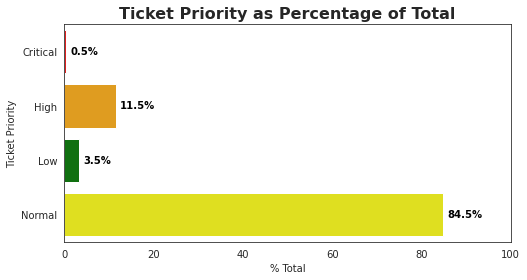

In [33]:
df = dataset
sns.set_style("white")

df2 = df.groupby('PriorityID').agg({'PriorityID':['count']}).reset_index()
df2.columns = ['PriorityID', 'count']
df2['pct'] = df2['count']*100/(sum(df2['count']))

x = df2['PriorityID']
y = df2['pct']

palette = ['red','orange', 'green', 'yellow']

fig, ax = plt.subplots(figsize = (8,4))
fig = sns.barplot(y, x, estimator = sum, ci = None, orient='h', palette=palette)

for i, v in enumerate(y):
  ax.text(v+1, i+.05, str(int(v)+.5)+'%', color='black', fontweight='bold')

ax.set(xlim=(0,100))
plt.title('Ticket Priority as Percentage of Total', size=16, weight='bold')
plt.ylabel('Ticket Priority')
plt.xlabel('% Total');

# D. Prepare BERT Train and Test Datasets

## D.1 Define BERT Layer

In [0]:
# Set maximum sequence length for BERT input datasets
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"

MAX_SEQ_LEN = 128

In [0]:
bert_layer = hub.KerasLayer(bert_path, 
                            trainable=True,
                            name="bert_layer")

input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                       dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                   dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                    dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
FullTokenizer = bert.bert_tokenization.FullTokenizer

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

## D.2 Create Train and Test Datasets

In [0]:
train, test = train_test_split(dataset,
                               test_size=0.2, 
                               shuffle=True)

In [38]:
print("train shape: ", train.shape)
print("test shape:  ", test.shape)

train shape:  (19359, 7)
test shape:   (4840, 7)


In [0]:
list_classes = ['label_pr_low', 'label_pr_norm', 'label_pr_high', 'label_pr_crit']

train_text = train.text
train_y = train[list_classes].values

test_text = test.text
test_y = test[list_classes].values

In [40]:
print(train_text.shape, "\ttrain_text shape")
print(train_y.shape, "\ttrain_y shape")

print()
print(test_text.shape, "\ttest_text shape")
print(test_y.shape, "\ttest_y shape")

(19359,) 	train_text shape
(19359, 4) 	train_y shape

(4840,) 	test_text shape
(4840, 4) 	test_y shape


In [41]:
train_x = create_input_array(train_text)
test_x = create_input_array(test_text)

100%|██████████| 4840/4840 [00:05<00:00, 954.52it/s]


In [47]:
print(len(train_x[0]), "\t\ttrain_x list of 3 (id, mask, segment) list length")
print(train_y.shape, "\ttrain_y shape")

print()
print(len(test_x[0]), "\t\ttest_x list of 3 (id, mask, segment) list length")
print(test_y.shape, "\ttest_y shape")

19359 		train_x list of 3 (id, mask, segment) list length
(19359, 4) 	train_y shape

4840 		test_x list of 3 (id, mask, segment) list length
(4840, 4) 	test_y shape


# X. Save File

In [0]:
# Save dataframe to shared Google drive project data folder
filename = "ticket_data_pp.csv"
ticket_data.to_csv(path_to_data + filename)